# Example 1
## Artifact detection and correction of residual ghost artifacts at R=1
In this post, I will explain to residual artifacts are generated, detected, and corrected across images acquired with four different phase-encoding directions (PEDs) namely: Left-right (LR), right-left (RL), anterior-posterior (AP), and posterior-anterior (PA)

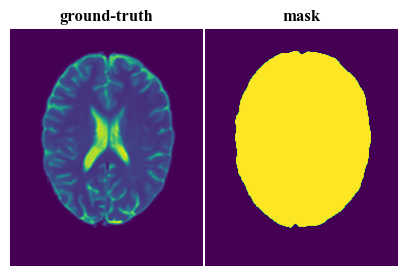

In [1]:
from setup import *
from sklearn import metrics

data_dir = 'data'
R=1
vba_th = 0.3
imgPlot = myPlot()
img2D = np.load(os.path.join(data_dir, 'gt_s90.npy'))
mask2D = np.load(os.path.join(data_dir, 'ma_s90.npy'))
_= imgPlot.show4imgs([img2D, mask2D], ['ground-truth', 'mask'], figSize=(5,5))

First, a slice of T2W image from existing in-vivo dataset, which served as an artifact-free ideal image, denoted as $I(x,y)$. 
The corresponding mask of ground-truth image is shown as $I_m(x,y)$. We assumed that image after all corrections and preprocessing steps are aligned with the T2W image and artifact-free. Hence, images acquired with four PEDs should be identical.

## Step 1: Generating Residual artifacts images. 
The reason why we generated only high-frequency components of original artifacts is because after corrections for detecting is without actual k-space data, it is almost impossible to visually detect residual ghost artifacts.  
Follow the Eqn (9) in the manuscript, the residual artifacts are generated, with corresponding to $S_o(k_x, k_y)$ and $S_e(k_x, k_y)$ from $I(x,y)$.


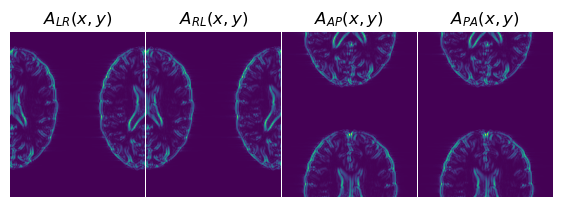

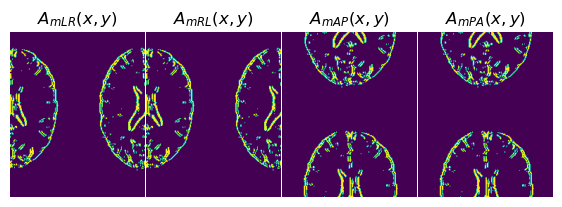

In [2]:
ghost4PEDFs = generate4PEDsGhosts(img2D, Omega = [1,1,1,1], R=R) # set default [1,1,1,1] 
_ = imgPlot.show4imgs(ghost4PEDFs, ['$A_{LR}(x,y)$','$A_{RL}(x,y)$', '$A_{AP}(x,y)$','$A_{PA}(x,y)$'])
artOtsu = np.squeeze(np.stack([compute_otsu_img(ghost4PEDFs[...,i]) for i in range(4)],axis = -1))
_ = imgPlot.show4imgs(artOtsu, ['$A_{mLR}(x,y)$', '$A_{mRL}(x,y)$', '$A_{mAP}(x,y)$', '$A_{mPA}(x,y)$'])


In this figures, the $\Omega$ values are set to 1. Hence in the Eqn (11), $\Omega A(x,y) = 1\times A(x,y)$  
## Step 2: Generate images with residual artifacts 


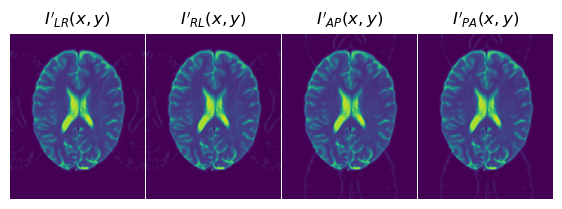

In [3]:
imgWArtifacts = img2D[..., np.newaxis] + ghost4PEDFs*artOtsu
_ = imgPlot.show4imgs(imgWArtifacts, ['$I\'_{LR}(x,y)$','$I\'_{RL}(x,y)$', '$I\'_{AP}(x,y)$','$I\'_{PA}(x,y)$'])


The case where residual artifacts affect the images at R=1. In this case all four images are affected by residual artifacts
## Step 3: Detection with only VBA

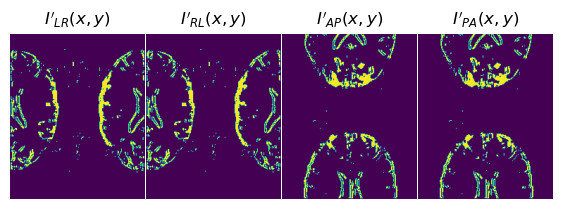

In [4]:
vba_arr = compute_vba_arr(imgWArtifacts)
_ = imgPlot.show4imgs(vba_arr>vba_th, [ '$I\'_{LR}(x,y)$','$I\'_{RL}(x,y)$', '$I\'_{AP}(x,y)$','$I\'_{PA}(x,y)$'])


As you can see clearly, without any modification VBA method can quickly detect the significant different across four images, any area that share the same information are not exceed the threshold. Only areas that are different from each others will show. 
Although it is sure that VBA can work alone, but dMRI is a complex data, hence separate the part that highly affected by the ghost artifacts is better.


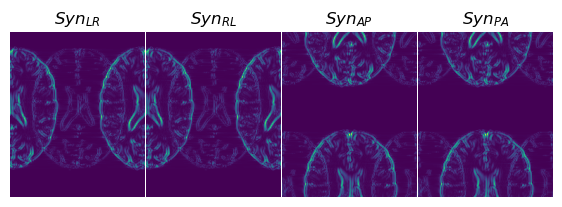

In [5]:
AP_syn = syntheticGhost(imgWArtifacts[...,0], 0,R)
PA_syn = syntheticGhost(imgWArtifacts[...,0], 0,R)
LR_syn = syntheticGhost(imgWArtifacts[...,0], 1,R)
RL_syn = syntheticGhost(imgWArtifacts[...,0], 1,R)

_ = imgPlot.show4imgs([ LR_syn, RL_syn,AP_syn, PA_syn], [ '$Syn_{LR}$','$Syn_{RL}$','$Syn_{AP}$', '$Syn_{PA}$'])


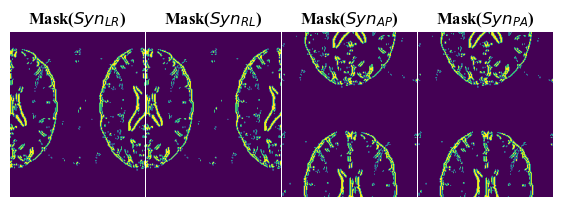

======================Detection metric of PED LR
recall score: 0.9976
acc score: 0.9843087923728814
precision score: 0.7796186308221319
dice score: 0.8752412703983155
======================Detection metric of PED RL
recall score: 0.9976
acc score: 0.9843087923728814
precision score: 0.7796186308221319
dice score: 0.8752412703983155
======================Detection metric of PED AP
recall score: 0.9986369831894594
acc score: 0.9778425141242938
precision score: 0.687089715536105
dice score: 0.8140740740740741
======================Detection metric of PED PA
recall score: 0.9986369831894594
acc score: 0.9778425141242938
precision score: 0.687089715536105
dice score: 0.8140740740740741


In [6]:
synOtsu = [compute_otsu_img(img) for img in [LR_syn, RL_syn,AP_syn, PA_syn]]
_ = imgPlot.show4imgs(synOtsu, [ 'Mask($Syn_{LR}$)','Mask($Syn_{RL}$)', 'Mask($Syn_{AP}$)', 'Mask($Syn_{PA}$)'])

detectedArtifacts = np.squeeze(np.stack(synOtsu, axis = -1)) * vba_arr > vba_th
peds = [ 'LR', 'RL','AP', 'PA']
for i in range(4):
    print('======================Detection metric of PED {}'.format(peds[i]))
    recall_score = metrics.recall_score(detectedArtifacts[...,i].ravel(), artOtsu[...,i].ravel())
    acc_score = metrics.accuracy_score(detectedArtifacts[...,i].ravel(), artOtsu[...,i].ravel())
    precision_score = metrics.precision_score(detectedArtifacts[...,i].ravel(), artOtsu[...,i].ravel())
    dice_score = compute_dice(detectedArtifacts[...,i], artOtsu[...,i])
    print('recall score: {}'.format(recall_score))
    print('acc score: {}'.format(acc_score))
    print('precision score: {}'.format(precision_score))
    print('dice score: {}'.format(dice_score))
    

In [7]:
## Example R=1 in the manuscript
def demonstrate_examples(R, Omegas = [1,1,1,1]):
    ghost4PEDFsCase = generate4PEDsGhosts(img2D, Omega = Omegas, R=R) # set default [1,1,1,1] 
    artOtsuCase = np.squeeze(np.stack([compute_otsu_img(np.abs(ghost4PEDFsCase[...,i])) for i in range(4)], axis = -1))*mask2D[..., np.newaxis]
    artOtsuCase = morp_closing(artOtsuCase)
    imgWArtifactsCase =  img2D[..., np.newaxis] + ghost4PEDFsCase*artOtsuCase
    vbaCase = compute_vba_arr(imgWArtifactsCase) 
    
    # Base on the acquisition parameter we already know R = 1
    AP_synCase = syntheticGhost(imgWArtifactsCase[...,0], 0,R) #Omega=1
    PA_synCase = syntheticGhost(imgWArtifactsCase[...,0], 0,R) #Omega=1
    LR_synCase = syntheticGhost(imgWArtifactsCase[...,0], 1,R) #Omega=1
    RL_synCase = syntheticGhost(imgWArtifactsCase[...,0], 1,R) #Omega=1
    synOtsuCase = [compute_otsu_img(img) for img in [LR_synCase, RL_synCase,AP_synCase, PA_synCase]]
    detectedArtifactsCase = np.squeeze(np.stack(synOtsuCase, axis = -1)) * vbaCase > vba_th
    detectedArtifactsCase = morp_closing(detectedArtifactsCase)
    # _ = imgPlot.show4imgs(ghost4PEDFsCase1*artOtsuCase1)
    # _ = imgPlot.show4imgs(artOtsuCase1)
    # _ = imgPlot.show4imgs(imgWArtifactsCase1)
    # _ = imgPlot.show4imgs(vbaCase1)
    # _ = imgPlot.show4imgs(detectedArtifactsCase1)
    for i in range(4):
        print('======================Detection metric of PED {}'.format(peds[i]))
        recall_score = metrics.recall_score(detectedArtifactsCase[...,i].ravel(), artOtsuCase[...,i].ravel())
        acc_score = metrics.accuracy_score(detectedArtifactsCase[...,i].ravel(), artOtsuCase[...,i].ravel())
        precision_score = metrics.precision_score(detectedArtifactsCase[...,i].ravel(), artOtsuCase[...,i].ravel())
        dice_score = compute_dice(detectedArtifactsCase[...,i], artOtsuCase[...,i])
        print('recall score: {}'.format(recall_score))
        print('acc score: {}'.format(acc_score))
        print('precision score: {}'.format(precision_score))
        print('dice score: {}'.format(dice_score))

In [8]:
Case1 = demonstrate_examples(1, [-1.3, 0,0,0])
Case2 = demonstrate_examples(1, [-1.3, 1.2,0,0])
Case3 = demonstrate_examples(1, [-1.3, 1.2,1.5,0])
Case4 = demonstrate_examples(1, [-1.3, 1.2,1.5,-0.9])

======================Detection metric of PED LR
recall score: 0.9569202566452796
acc score: 0.9955199505649718
precision score: 0.87
dice score: 0.9113924050632911
======================Detection metric of PED RL
recall score: 0.0
acc score: 1.0
precision score: 0.0
dice score: nan
======================Detection metric of PED AP
recall score: 0.0
acc score: 1.0
precision score: 0.0
dice score: nan
======================Detection metric of PED PA
recall score: 0.0
acc score: 1.0
precision score: 0.0
dice score: nan


C:\Users\thaias\AppData\Local\anaconda3\envs\nyqimages\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\thaias\AppData\Local\anaconda3\envs\nyqimages\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\thaias\AppData\Local\anaconda3\envs\nyqimages\lib\site-packages\scipy\spatial\distance.py:1424: RuntimeWarning: invalid value encountered in double_scalars
  return float((ntf + nft) / np.array(2.0 * ntt + ntf + nft))


======================Detection metric of PED LR
recall score: 0.964319248826291
acc score: 0.9953433968926554
precision score: 0.8558333333333333
dice score: 0.9068432671081678
======================Detection metric of PED RL
recall score: 0.9612476370510397
acc score: 0.9950564971751412
precision score: 0.8475
dice score: 0.9007971656333038
======================Detection metric of PED AP
recall score: 0.0
acc score: 1.0
precision score: 0.0
dice score: nan
======================Detection metric of PED PA
recall score: 0.0
acc score: 1.0
precision score: 0.0
dice score: nan
======================Detection metric of PED LR
recall score: 0.9629981024667932
acc score: 0.9950564971751412
precision score: 0.8458333333333333
dice score: 0.9006211180124224
======================Detection metric of PED RL
recall score: 0.9586349534643226
acc score: 0.9930923375706214
precision score: 0.7725
dice score: 0.8555606829718505
======================Detection metric of PED AP
recall score: 0.975440